In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with zipfile.ZipFile('data/training.zip') as zip:
    with zip.open('training.csv') as myZip:
        df = pd.read_csv(myZip)

In [3]:
four_keypoints_df = df.loc[:, ['nose_tip_x', 'nose_tip_y',
                               'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                               'left_eye_center_x', 'left_eye_center_y',
                               'right_eye_center_x', 'right_eye_center_y',
                               'Image']
                          ].dropna().reset_index(drop=True)

four_keypoints_df.shape

(7000, 9)

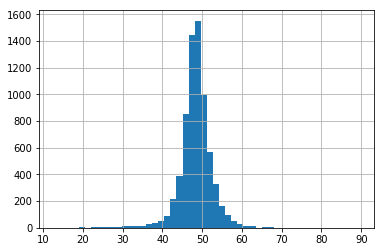

In [4]:
four_keypoints_df.nose_tip_x.hist(bins=50)

In [5]:
uniform_df = pd.DataFrame(columns=four_keypoints_df.columns)

for i in range(24):
    for j in range(24):
        x_mask = (four_keypoints_df['nose_tip_x'] >= i*4) & (four_keypoints_df['nose_tip_x'] < i*4+4)
        y_mask = (four_keypoints_df['nose_tip_y'] >= j*4) & (four_keypoints_df['nose_tip_y'] < j*4+4)
        target_pixel_data = four_keypoints_df[x_mask & y_mask]
        if len(target_pixel_data) == 0:
            pass
        elif len(target_pixel_data) <= 20:
            uniform_df = pd.concat([uniform_df, target_pixel_data])
        else:
            uniform_df = pd.concat([uniform_df, target_pixel_data.sample(10, random_state=19)])

In [23]:
uniform_df = uniform_df.reset_index(drop=True)
uniform_df.shape

(604, 9)

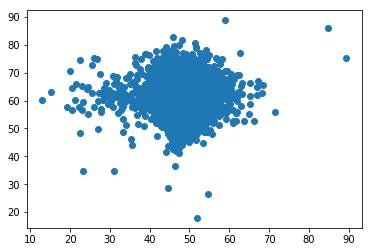

In [7]:
plt.scatter(four_keypoints_df.nose_tip_x, four_keypoints_df.nose_tip_y)

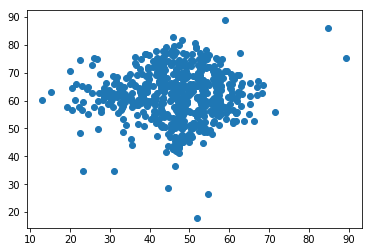

In [8]:
plt.scatter(uniform_df.nose_tip_x, uniform_df.nose_tip_y)

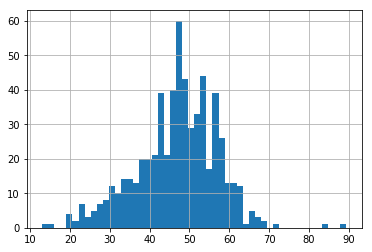

In [9]:
uniform_df.nose_tip_x.hist(bins=50)

In [41]:
a, b, c, d = np.split(uniform_df.sample(len(uniform_df)), 4)

In [68]:
from lib.image_generator import adjust_contrast, flip_images, rotate_images

In [70]:
%%time
rotated_cw_5 = rotate_images(a, 5)
rotated_ccw_10 = rotate_images(b, -10)
rotated_cw_15 = rotate_images(c, 15)
rotated_ccw_20 = rotate_images(d, -20)

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


In [71]:
mixed_data_1 = pd.concat([uniform_df,
                          rotated_cw_5,
                          rotated_ccw_10,
                          rotated_cw_15,
                          rotated_ccw_20]).reset_index(drop=True)
mixed_data_1.shape

(1208, 9)

In [72]:
a, b, c, d = np.split(mixed_data_1.sample(len(mixed_data_1)), 4)

In [75]:
%%time
adj_cont_20 = adjust_contrast(a, .2)
adj_cont_50 = adjust_contrast(b, .5)
adj_cont_80 = adjust_contrast(c, .8)
adj_cont_110 = adjust_contrast(d, 1.2)

CPU times: user 7.61 s, sys: 20 ms, total: 7.63 s
Wall time: 7.63 s


In [77]:
mixed_data_2 = pd.concat([mixed_data_1,
                          adj_cont_20,
                          adj_cont_50,
                          adj_cont_80,
                          adj_cont_110]).reset_index(drop=True)
mixed_data_2.shape

(2416, 9)

In [78]:
%%time
flipped_images_df = flip_images(mixed_data_2)

CPU times: user 19.9 s, sys: 190 ms, total: 20.1 s
Wall time: 20.1 s


In [79]:
mixed_data_final = pd.concat([mixed_data_2, flipped_images_df]).reset_index(drop=True)
mixed_data_final.shape

(4832, 9)

In [80]:
from sklearn.utils import shuffle

In [81]:
mixed_data_final = shuffle(mixed_data_final).reset_index(drop=True)

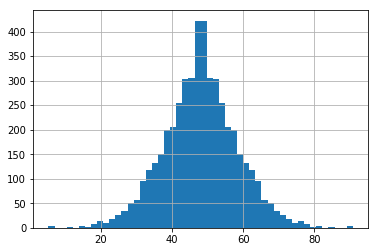

In [82]:
mixed_data_final.nose_tip_x.hist(bins=50)

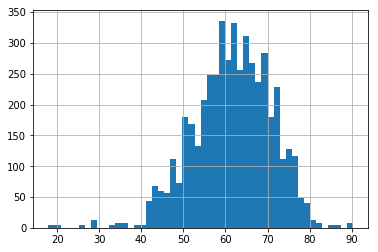

In [83]:
mixed_data_final.nose_tip_y.hist(bins=50)

In [84]:
mixed_data_final.to_pickle('mixed_data_final_2.data')

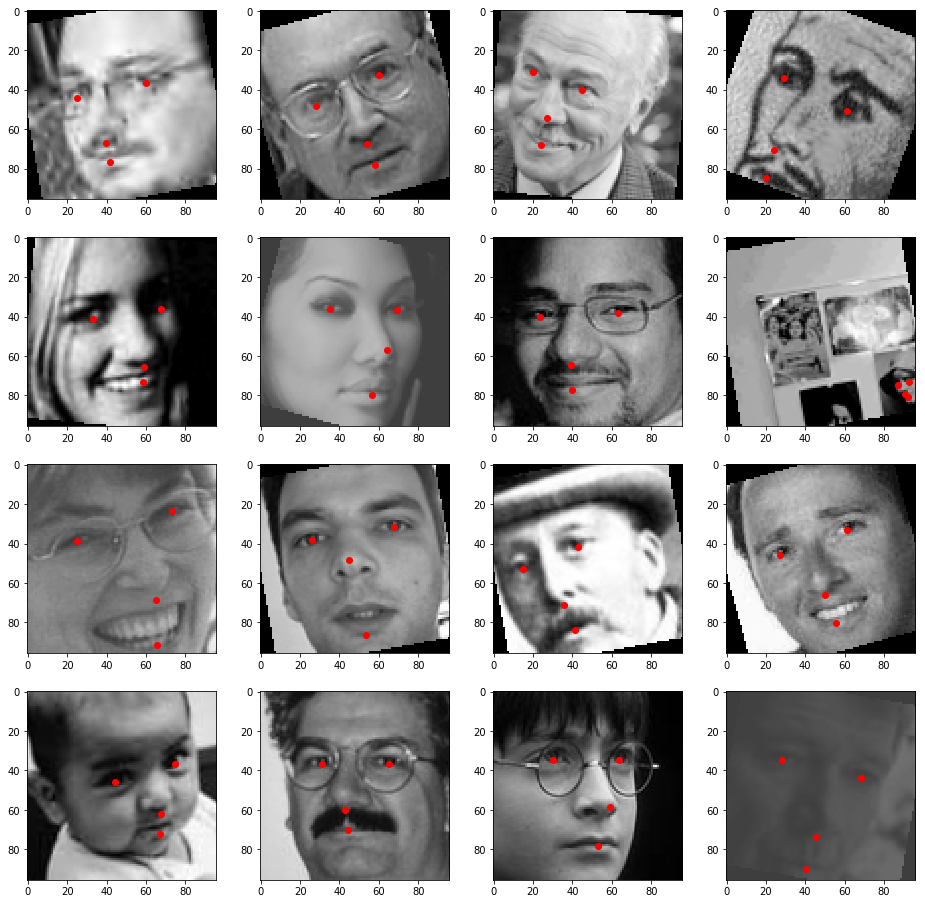

In [85]:
f, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        for k in range(4):
            ax[i, j].plot(mixed_data_final.iloc[i*4 + j, 2*k], mixed_data_final.iloc[i*4 + j, 2*k+1], c='r', marker='o')
        ax[i, j].imshow(np.fromstring(mixed_data_final.loc[i*4 + j, 'Image'], sep=' ').reshape(96, 96), cmap='gray', vmin=0, vmax=255)